# Notes

This assignment is partially autograded. Problems 2 and 3 are graded manually according to the following rules:

- **1 point**: attempt was made, but solution is not correct,
- **2 points**: solution is generally correct, but is not efficient/has unreasonably low performance,
- **3 points**: solution is correct, is efficient/has reasonably high performance *(maximum grade for Problem 3)*.

Problem 1 is auto-graded. The maximum grade is **2 points** for Problem 2 and **3 points** for Problem 3.

In [ ]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [ ]:
plt.rcParams["figure.figsize"] = (6,6)

In [ ]:
import numpy as np
import torch
from sklearn import datasets

In [ ]:
STUDENT = ""
ASSIGNMENT = 3
TEST = True

In [ ]:
if TEST:
    # import solutions
    total_grade = 0
    MAX_POINTS = 6

# Gradients

### 1. Generate gradient (1 point).

For 2-dimensional tensor `tr`, calculate a gradient of $\sum\log tr_{ij}$. Note, that you're provided with dimensions and interval, and not the `tr` inself:

- `dims` is a tuple, so that `tr.size()` equals `dims`,
- `lims` is an interval, so that elements of `tr` are integeres, uniformly sampled from `[lims[0], lims[1])` interval (note, that lims[1] is **not** included).

Result must be a tensor of the same shape as `tr` (namely, `dims`), containing gradients of the following function:

$$\sum_{ij}\log tr_{ij}.$$

and generated `tr` itself.

Result **will be tested against multiple random combinations of input tensor dimensions ($10 \leq n < 100 $) and sampling interval (`lims[0]=1`, `10 <= lims[1] < 100`)**.

**Hint**: think on how you can validate the solution yourself, given that gradient can be computed manually on paper.

In [ ]:
def generate_grad(dims, lims):
    """Generate gradient of `log(x)`."""
    tr = torch.FloatTensor(dims[0],dims[1]).uniform_(lims[0],lims[1]).requires_grad_()
    
    f = torch.log(tr).sum()
    f.backward()
    
    
    return tr.grad, tr

In [ ]:
ag, a = generate_grad((23, 5), (24, 92))
assert torch.allclose(a, 1/ag)

ag, a = generate_grad((58, 63), (15, 63))
assert torch.allclose(a, 1/ag)

ag, a = generate_grad((10, 100), (1, 23)) 
assert torch.allclose(a, 1/ag)

In [ ]:
PROBLEM_ID = 1
GRADE = 1

if TEST:
    total_grade += GRADE

### 2. Find a minimum (2 points, manually graded).

Consider the following scalar function:

$$
f(x) = ax^2 + bx + c
$$

Given the $a,b,c$, find $x$, which minimizes $f(x)$. Note this:

- $a,b,c$ are fixed, and generated in such a way, that minimum always exists ($f(x)$ is convex),
- $x$ is a scalar value, i.e. 0-dimensional tensor.

**Hint:** stop for a second to think about which tensor must contain `requires_grad` and on which scalar should `.backward()` be called.

In [ ]:
def generate_coeffs():
    a = torch.rand(size=()) * 10
    b = -10 + torch.rand(size=()) * 10
    c = -10 + torch.rand(size=()) * 10
    return a, b, c

def func(x, a, b, c):
    return x.pow(2) * a + x * b + c

In [ ]:
EPOCHS = 20
DELTA = 0.00001
LR = 1e-1
#Given that Xminimum is -b\2a, -10 < b < 0, 0<a<10 in most (but not all) cases 0 < Xmin(f) < 10 so 
#the middle of this interval may be a good start
STARTING_VAL = 5. 


# Initialize x, a, b, c
x = torch.zeros((1))
x.add_(STARTING_VAL)
x.requires_grad_()

a, b, c = generate_coeffs()

# Collect f(x) values during training for visuzalition later on
f_vals = []

for i in range(EPOCHS):
    y=func(x,a,b,c)
    y.backward()
    
    f_vals.append(y.item())

    with torch.no_grad():
        x.sub_(LR * x.grad)
        
    x.grad.zero_()
   

    print(f"Epoch {i}: y = {f_vals[-1]}")
    
    try:
        if f_vals[-2] - f_vals[-1] < DELTA:
            print(x.item())
            break
    except:
        pass

Epoch 0: y = -4.273480415344238
Epoch 1: y = -4.883937835693359
Epoch 2: y = -5.390192985534668
Epoch 3: y = -5.81003475189209
Epoch 4: y = -6.158210754394531
Epoch 5: y = -6.446955680847168
Epoch 6: y = -6.686413764953613
Epoch 7: y = -6.884997367858887
Epoch 8: y = -7.049684524536133
Epoch 9: y = -7.186260223388672
Epoch 10: y = -7.299523830413818
Epoch 11: y = -7.393453121185303
Epoch 12: y = -7.471350193023682
Epoch 13: y = -7.53594970703125
Epoch 14: y = -7.589522838592529
Epoch 15: y = -7.633951187133789
Epoch 16: y = -7.6707963943481445
Epoch 17: y = -7.701352119445801
Epoch 18: y = -7.726692199707031
Epoch 19: y = -7.747706890106201


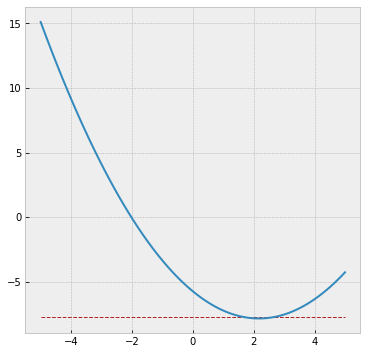

In [ ]:
if f_vals:
    grid = np.linspace(-5, 5, 100)
    plt.plot(grid, np.square(grid) * a.item() + grid * b.item() + c.item())
    plt.hlines(f_vals[-1], -5, 5, "firebrick", "--", linewidth=1)

In [ ]:
PROBLEM_ID = 2
GRADE = 2

if TEST:
    total_grade += GRADE

### 3. Simple neural network model (3 points, manually graded).

Construct a non-linear model for binary classification. Use logistic regression example from Week 3 lecture as a blueprint. Experiment with different number of intermediate layers and their sizes to achieve good performance.

For a reference, imagine a neural network with a single hidden layer with $N$ neurons. Then, input $X$ is first transformed as:

$$
X^{hidden}_{ik} = \sigma(X_{ij}W^{hidden}_{jk} + b^{hidden}_k),
$$
$$
\hat y_{i} = \sigma(X^{hidden}_{ij}W_{j} + b).
$$

After this, $X^{hidden}_{ik}$ can be considered as an input to the same logistic regression model we had in class. The bonus is that we performed non-linear transformation of the original coordinates and can now catch non-linear decision boundary (as is the case for the mock data below).

Note also, that $X$ has shape $(N, 2)$ (where $N$ is the number of training examples), $W^{hidden}_{jk}$ has shape of $(2, N^{hidden})$ and $b^{hidden}_k$ has shape $(N^{hidden})$. At the same time, $W$ has shape $(N^{hidden},)$ and $b$ is a scalar (the same way it was for logistic regression). This model can be considered as a logistic regression on transformed coordinates, but we learn the transformation itself.

**Validation criterion for full grade on this problem:** achieve accuracy of at least `0.94` **and** use no more than one hidden layer with no more than 6 neurons.

In [ ]:
N_LAYERS = 2
N_HIDDEN = [(2,6),(6,1)]

In [ ]:
X, y = datasets.make_moons(1000, noise=.25)

In [ ]:
Xt = torch.tensor(X, dtype=torch.float)
yt = torch.tensor(np.expand_dims(y, axis=-1), dtype=torch.float)

In [ ]:
weights = []
biases = []

 
for i in range(N_LAYERS):
    # Initialize w and b for layer i with number of "neurons" of N_HIDDEN[i]
    
    w = torch.empty(N_HIDDEN[i])
    torch.nn.init.xavier_normal_(w, gain=1.0)
    w.requires_grad_()
    b = torch.randn(1,N_HIDDEN[i][1], requires_grad=True)
    
    weights.append(w)
    biases.append(b)


In [ ]:
weights, biases

([tensor([[-1.1046,  0.1295, -0.2948, -0.1946,  0.2655,  0.5710],
          [-0.4789,  0.3283,  0.2196,  0.6863,  0.0527,  0.3245]],
         requires_grad=True), tensor([[ 1.4665],
          [ 0.4361],
          [-0.1916],
          [ 0.4954],
          [ 0.4963],
          [ 0.1913]], requires_grad=True)],
 [tensor([[-0.1367,  0.1355, -0.8774, -0.6937,  0.1752, -1.2739]],
         requires_grad=True), tensor([[0.0729]], requires_grad=True)])

In [ ]:
def sigmoid(a):
    """Sigmoid activation function."""

    return 1/(1 + (-a).exp())

def output(X, weights, biases):
    y_t=sigmoid(torch.mm(X, weights[0]) + biases[0])
      
    for idx, (w1,b1) in enumerate(zip(weights[1:], biases[1:])):
        y_t=sigmoid(torch.mm(y_t, w1) + b1)
   
    return y_t

def logloss(y, y_pred):
    return -(y * torch.log(y_pred) + (1 - y) * torch.log(1 - y_pred)).mean()

In [ ]:
EPOCHS = 5200
LR = 20e-1
DELTA = 0.000000001
loss_history = []

for i in range(EPOCHS):
    y_pred = output(Xt, weights, biases)
    loss = logloss(yt, y_pred)
    loss.backward()
    loss_history.append(loss.item())

    with torch.no_grad():
        [w.sub_(LR * w.grad) for w in weights]
        [b.sub_(LR * b.grad) for b in biases]
     
    # wipe out all gradients
    [w.grad.zero_() for w in weights]
    [b.grad.zero_() for b in biases]
    
    if i % 20 == 0:
        print(f"Epoch {i}: loss = {loss_history[-1]}")
    
    try:
        if loss_history[-2] - loss_history[-1] < DELTA:
            break
    except:
        pass

Epoch 0: loss = 0.9504106044769287
Epoch 20: loss = 0.3828326165676117
Epoch 40: loss = 0.3247098922729492
Epoch 60: loss = 0.314549058675766
Epoch 80: loss = 0.3123874366283417
Epoch 100: loss = 0.3117183744907379
Epoch 120: loss = 0.3113727271556854
Epoch 140: loss = 0.31112003326416016
Epoch 160: loss = 0.31090837717056274
Epoch 180: loss = 0.3107226490974426
Epoch 200: loss = 0.31055647134780884
Epoch 220: loss = 0.3104058802127838
Epoch 240: loss = 0.3102680742740631
Epoch 260: loss = 0.3101409673690796
Epoch 280: loss = 0.3100229501724243
Epoch 300: loss = 0.3099125921726227
Epoch 320: loss = 0.3098089098930359
Epoch 340: loss = 0.30971094965934753
Epoch 360: loss = 0.3096180558204651
Epoch 380: loss = 0.30952954292297363
Epoch 400: loss = 0.3094449043273926
Epoch 420: loss = 0.30936378240585327
Epoch 440: loss = 0.30928564071655273
Epoch 460: loss = 0.30921030044555664
Epoch 480: loss = 0.3091374337673187
Epoch 500: loss = 0.30906668305397034
Epoch 520: loss = 0.3089979290962219

In [ ]:
accuracy = np.sum(y == (y_pred.detach().numpy().flatten() > 0.5))/1000
print("Accuracy is %f" % accuracy)

Accuracy is 0.953000


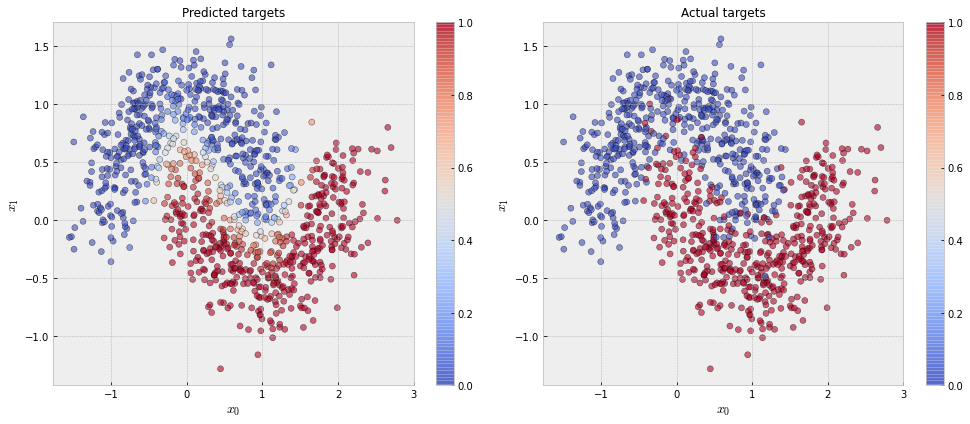

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred.detach().numpy().flatten(), alpha=0.6, edgecolor='k',
            cmap=plt.cm.coolwarm, vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('$x_1$', fontsize=14)
plt.title("Predicted targets", fontsize=12)

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.6, edgecolor='k',
            cmap=plt.cm.coolwarm, vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('$x_1$', fontsize=14)
plt.title("Actual targets", fontsize=12)
plt.tight_layout()

In [ ]:
PROBLEM_ID = 3
GRADE = 3

if TEST:
    total_grade += GRADE

In [ ]:
if TEST:
    print(f"{STUDENT}: {int(100 * total_grade / MAX_POINTS)}")

Dana Rozenblum and Nitzan Tal: 100
